Cell 1 (imports + DB connection)

In [1]:
from pathlib import Path

import sqlite3

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

project_root = Path.cwd().parent

db_path = project_root / "data" / "Synthetic Dataset" / "product_analytics.db"

conn = sqlite3.connect(db_path)

Cell 2 (rebuild strategy returns)

In [4]:
query = """ 

SELECT

    DATE(order_ts) AS day,

    SUM(net_revenue) AS revenue

FROM orders

GROUP BY day

ORDER BY day;

"""

ts = pd.read_sql_query(query, conn)

ts["day"] = pd.to_datetime(ts["day"])

ts = ts.set_index("day")

ts["returns"] = ts["revenue"].pct_change()

short_window = 5

long_window = 20 

ts["ma_short"] = ts["revenue"].rolling(short_window).mean()

ts["ma_long"] = ts["revenue"].rolling(long_window).mean()

ts.dropna(inplace=True)

ts["signal"] = (ts["ma_short"] > ts["ma_long"]).astype(int)

ts["position"] = ts["signal"].shift(1) # shift to avoid lookahead

ts.dropna(inplace=True)

Cell 3 (base strategy returns "no costs")

In [5]:
ts["strategy_returns_gross"] = ts["position"] * ts["returns"]

ts[["returns", "strategy_returns_gross"]].head()

,returns,strategy_returns_gross
day,,
2024-01-21,0.269414,0.269414
2024-01-22,0.374118,0.374118
2024-01-23,-0.171161,-0.171161
2024-01-24,-0.284129,-0.284129
2024-01-25,-0.019063,-0.019063


Cell 4 (turnover / trades "when switching positions)

   - A "trade" happens when position changes (0 --> 1 or 1 --> 0)
   - Trade = 1 means the position changed that day.

In [6]:
ts["trade"] = ts["position"].diff().abs().fillna(0)

ts["trade"].value_counts()

trade
0.0    576
1.0    134
Name: count, dtype: int64

Cell 5 (add cost + slippage)

   - Realistic cost model "simple but effective."
   - Example assumptions:
   - Cost per trade = 0.10% (10 bps) each time positions changes.
   - Slippage per trade = 0.05% (5 bps)

In [10]:
cost_bps = 10            # 10 basis points

slippage_bps = 5         # 5 basis points

friction = (cost_bps + slippage_bps) / 10000 # convert bps to decimal

ts["cost"] = ts["trade"] * friction

ts["strategy_returns_net"] = ts["strategy_returns_gross"] - ts["cost"]

ts[["strategy_returns_gross", "cost", "strategy_returns_net"]].head()

,strategy_returns_gross,cost,strategy_returns_net
day,,,
2024-01-21,0.269414,0.0,0.269414
2024-01-22,0.374118,0.0,0.374118
2024-01-23,-0.171161,0.0,-0.171161
2024-01-24,-0.284129,0.0,-0.284129
2024-01-25,-0.019063,0.0,-0.019063


Cell 6 (compare equity curves)

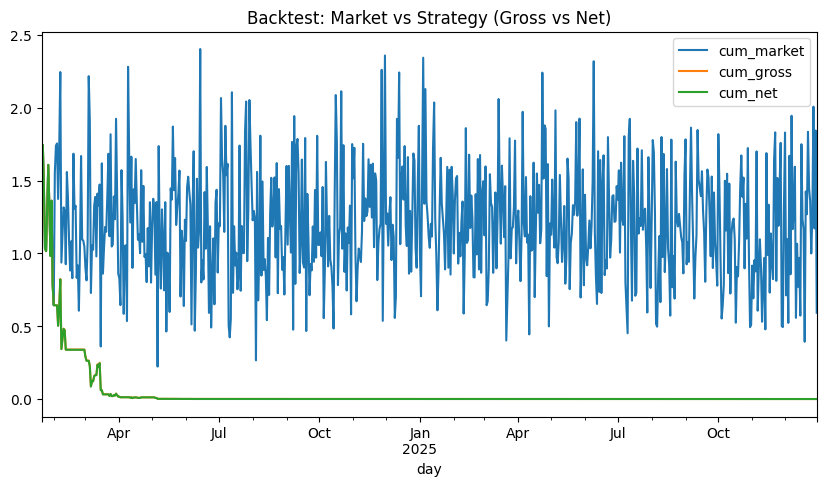

In [11]:
ts["cum_gross"] = (1 + ts["strategy_returns_gross"]).cumprod()

ts["cum_net"] = (1 + ts["strategy_returns_net"]).cumprod()

ts["cum_market"] = (1 + ts["returns"]).cumprod()

ts[["cum_market", "cum_gross", "cum_net"]].plot(

    title="Backtest: Market vs Strategy (Gross vs Net)",

    figsize=(10, 5)

)

plt.show()

Cell 7 (key metrics: turnover + cost impact)

In [12]:
n_trades = ts["trade"].sum()

avg_cost_per_day = ts["cost"].mean()

total_cost = ts["cost"].sum()

n_trades, avg_cost_per_day, total_cost

(np.float64(134.0), np.float64(0.0002830985915492958), np.float64(0.201))

sharpe like comparison

In [13]:
def sharpe(x):

    return x.mean() / x.std()

sharpe_gross = sharpe(ts["strategy_returns_gross"])

sharpe_net = sharpe(ts["strategy_returns_net"])

sharpe_gross, sharpe_net

(np.float64(-0.027238476221502928), np.float64(-0.02817274642110354))

## Day 7 – Costs & Slippage Insights

- Transaction costs and slippage reduce performance, especially for high-turnover strategies.
- Turnover is a key hidden driver of backtest fragility.
- A strategy must be evaluated net of costs to be realistic.
- Comparing gross vs net results quantifies whether the edge survives friction.

This step is essential to avoid overestimating real-world performance.